<div >
<img src = "../banner.png" />
</div>

# Datos Espaciales y Estimación de Densidades para el Análisis de Puntos Calientes. 

Este *cuaderno* complementa el cuaderno anterior de datos espaciales y hace una introducción a la Estimación de Densidades para el Análisis de Puntos Calientes. 


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ignaciomsarmiento/RecomSystemsLectures/blob/main/L09_OSM/L09_OSM_Density.ipynb)

## Adquiriendo datos espaciales abiertos: [OpenStreetMap](https://www.openstreetmap.org/)


OpenStreetMap (OSM) es probablemente la base de datos espacial abierta más conocida y ampliamente utilizada en el mundo. Esta base, de licencia abierta y gratuita, contiene mapas e información geográfica construida por voluntarios alrededor del mundo.

Veremos en esta sección cómo podemos recuperar datos de OSM utilizando la librería `pirosm`. OSM es una "base de datos del mundo", y por lo tanto contiene información sobre varias cosas: Con `pirosm` se pueden descargar y extraer datos  sobre:

   - Calles, con la función `osm.get_network()`
   - Edificios, con la función `osm.get_buildings()`
   - Puntos de interés, con la función `osm.get_pois()`
   - Uso de la tierra, con la función `osm.get_landuse()`
   - Elementos naturales, con la función `osm.get_natural()`
   - Fronteras, con la función `osm.get_boundaries()`

Para ilustrarlo descarguemos los supermercados en Bogotá:

In [ ]:
#Instalamos las librerias a utilizar
!pip install shapely==1.8.5
pip install pyrosm
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Cargamos geopandas que es la librería a utilizar
import geopandas as gpd

#Cargamos los datos de establecimientos
bares = gpd.read_file("/content/drive/MyDrive/datos/egba") 
ciclovias = gpd.read_file("/content/drive/MyDrive/datos/Ciclovia")
upla = gpd.read_file("/content/drive/MyDrive/datos/upla")

/usr/local/lib/python3.9/dist-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [ ]:
from pyrosm import OSM, get_data
from shapely.geos import lgeos
# Bajamos los datos para  Bogotá
fp = get_data("Bogota")

# Inicializamos el lector para Bogotá
osm = OSM(fp)

In [ ]:
#Obtenenemos los supermecados
super = osm.get_pois(custom_filter={"shop":["supermarket"]})
len(super)

/usr/local/lib/python3.9/dist-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/usr/local/lib/python3.9/dist-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


1626

In [ ]:
super.head()

,changeset,lat,tags,lon,id,version,timestamp,addr:city,addr:full,addr:housenumber,...,name,opening_hours,operator,phone,website,organic,shop,geometry,osm_type,addr:country
0,0.0,4.726381,None,-74.060181,265686842,0,0,None,None,None,...,Carulla,None,None,None,None,None,supermarket,POINT (-74.06018 4.72638),node,NaN
1,0.0,4.681126,None,-74.049553,345260678,0,0,None,None,None,...,Chico Centro,None,None,None,None,None,supermarket,POINT (-74.04955 4.68113),node,NaN
2,0.0,4.698651,"{""brand"":""Ol\u00EDmpica"",""brand:wikidata"":""Q24...",-74.042747,356119972,0,0,None,None,None,...,Olímpica,None,Olimpica,None,None,None,supermarket,POINT (-74.04275 4.69865),node,NaN
3,0.0,4.694653,None,-74.056602,356121996,0,0,None,None,None,...,None,None,Surtifruver,None,None,None,supermarket,POINT (-74.05660 4.69465),node,NaN
4,0.0,4.699185,"{""wheelchair"":""yes""}",-74.029388,361325638,0,0,None,None,None,...,Supermercado Colsubsidio,None,None,None,None,None,supermarket,POINT (-74.02939 4.69918),node,NaN


Obtuvimos entonces datos de 1478 supermercados con su ubicación en la ciudad, que podemos también agregar a nuestro mapa anterior. Notemos además que esta base contiene tanto puntos como polígonos.

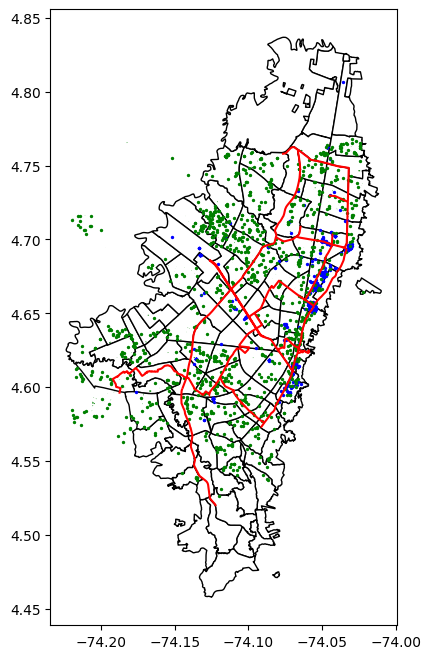

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
filtro = ~upla["UPlNombre"].str.contains("RIO")
upla.loc[filtro,:].plot(ax = ax, color = 'white', edgecolor = 'black');
ciclovias.to_crs(4686).plot(ax = ax, color = "red"); 
bares.plot(ax = ax, markersize = 2, color = "blue");
super.plot(ax = ax, markersize = 2, color = "green");

## Proyecciones geográficas


La Tierra no es plana. El mundo es un elipsoide de forma irregular, pero los dispositivos en los que representamos los mapas tienen sólo dos dimensiones. Para representar la Tierra, se la reproyecta en un mapa plano. 

La proyección cartográfica elegida determinará cómo se transforman y distorsionan latitudes y longitudes para preservar algunas de las propiedades del mapa: área, forma, distancia, dirección o rumbo. Por ejemplo, los marineros usan la proyección de Mercator donde los meridianos y los paralelos se cruzan entre sí siempre en el mismo ángulo de 90 grados. Les permite ubicarse fácilmente en la línea que muestra la dirección en la que navegan. Pero la proyección no conserva las distancias. 

El sigiente `.gif` ilustra cómo la proyección Mercator "aplana" la tierra:

In [ ]:
from IPython.display import IFrame
IFrame('figs/Projections.gif', width=700, height=350)

Entonces, las proyecciones cartográficas intentan representar la superficie de la tierra o una parte de ella, en una superficie plana de papel o en la pantalla del computador.

El sistema de coordenadas de referencia (o `CRS` por sus siglas en ingles) define con la ayuda de las coordenadas, cómo la representación bidimensional de la tierra se relaciona con la ubicación real en la tierra. 

Existen varios `CRS` y la eleccion dependerá de lo que se quiere hacer. Roger Bivand y coautores (2013)  plasman esto de manera muy clara: “No existen proyecciones para todos los propósitos, todas implican distorsión cuando están lejos del centro del marco especificado” 

Por ejemplo tenemos sistemas de coordenadas que abarcan todo el globo terráqueo y sirven para ubicar cualquier punto de la Tierra sin necesitar otro punto de referencia. El más popular es el WGS84 (World Geodetic System 1984), cuyo código EPSG: 4326 (EPSG es un registro público con todas las proyecciones y su respectivo código).

Por otro lado, los sistemas de coordenadas proyectadas que se focalizan le dicen al computador cómo graficar en usa superficie plana para minimizar la distorsión visual en una región particular. Por ejemplo, para Colombia se recomienda utilizar el  MAGNA-SIRGAS cuyo código EPSG : 4626.


Volviendo un poco a las bases anteriores, notemos que las latitudes y longitudes, de las ciclovías están expresadas de forma diferente que el resto. Esto se debe a que están en una proyección diferente. ¿Cómo podemos ver en que proyección están los datos? Para ello usamos la función `.crs`

In [ ]:
ciclovias.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

En este caso, están en Pseudo-Mercator (EPSG: 3857) mientras que la base de bares está en la proyección recomendada para Colombia: MAGNA-SIRGAS

In [ ]:
bares.crs   

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Para poder graficar y trabajar con estas bases es importante siempre verificar las proyección en la que se encuentran y homogeneizarlas, para ello se puede usar la función `.to_crs`. 

In [ ]:
ciclovias=ciclovias.to_crs(4686)
ciclovias.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

Esto será especialmente importante para medir distancias.

## Midiendo distancias

Cuando trabajamos con datos geográficos a menudo nos va a interesar medir distancias, esto será especialmente importante cuando queremos agrupar datos y encontrar "puntos calientes". Para demostrarlo, generaremos datos espaciales, creando primero un `DataFrame` con [pandas](https://pandas.pydata.org/pandas-docs/stable/) y luego transformarlo a un `GeoDataFrame` de [geopandas](https://geopandas.org/).

Para nuestro ejemplo vamos a medir la distancia entre la Universidad de Los Andes y el Banco de la República. Entonces primero generamos el DataFrame que tiene columnas: lugar, latitud y longitud.


In [ ]:
import pandas as pd
db = pd.DataFrame({
    "lugar": ["Uniandes", "Banco de la República"],
    "lat": [4.601590, 4.602151],
    "long": [-74.066391, -74.07221]
    })
db

,lugar,lat,long
0,Uniandes,4.601590,-74.066391
1,Banco de la República,4.602151,-74.072210


Lo transformamos a un `GeoDataFrame` especificando que la geometría son puntos que surgen de la latitud y longitud:

In [ ]:
db = gpd.GeoDataFrame(db, geometry = gpd.points_from_xy(db.long, db.lat))
db

,lugar,lat,long,geometry
0,Uniandes,4.601590,-74.066391,POINT (-74.06639 4.60159)
1,Banco de la República,4.602151,-74.072210,POINT (-74.07221 4.60215)


Definimos la proyección WGS84, ya que tenemos la latidues y longitudes que los ubican en el mapa, pero luego lo proyectamos a MAGNA-SIRGAS para tener la proyección que corresponde a Bogotá.

In [ ]:
db.crs = "EPSG:4326"
db=db.to_crs(4686)

Antes de calcular la distancia, grafiquemos las ubicaciones en sus respectivas UPLs.

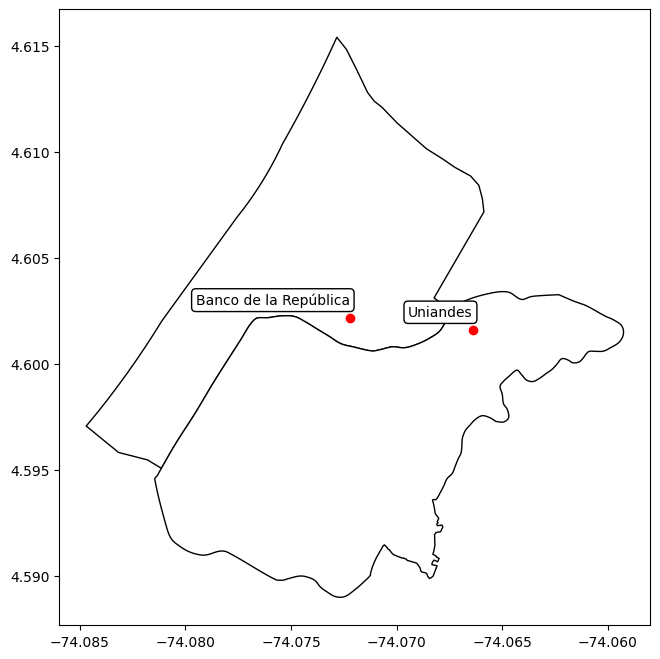

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
# La Universidad de los Andes y el Banco de la República quedan en las localidades 
filtro = upla.UPlNombre.isin(["LA CANDELARIA", "LAS NIEVES"])
upla.loc[filtro,:].plot(ax = ax, color = "white", edgecolor = "black");
db.plot(ax = ax, color = "red");

# Para poder crear una marcación de los lugares necesitamos desempaquetar la geometría
db["coordenadas"] = db["geometry"].apply(lambda x: x.representative_point().coords[:][0])
for idx, fila in db.iterrows():
    plt.annotate(text = fila['lugar'], xy = fila['coordenadas'], 
        textcoords = 'offset points', xytext = (0, 10), ha = 'right',
        bbox = dict(boxstyle = "round", fc = "white"))

Para calcuar la distancia   entre Uniandes y el Banco de la República vamos a utilizar la función `distance` de la librería [geopy](https://geopy.readthedocs.io/en/stable/). [Geopy](https://geopy.readthedocs.io/en/stable/) es un cliente de `Python` que permite acceder a servicios web de geocodificación populares y facilita el cálculo de distancias entre ubicaciones.

In [ ]:
from geopy.distance import geodesic

coords_1 = db.coordenadas[0]
coords_2 = db.coordenadas[1]


geodesic(coords_1, coords_2).m


649.6801561296176

[Geopy](https://geopy.readthedocs.io/en/stable/) nos dice entonces que la distancia entre el Banco de la República y Uniandes es aproximadamente 650 metros. Esta distancia es aproximadamente la misma que obtenemos si la medimos directamente en  [Google Maps](https://www.google.com/maps/dir/4.602146,+-74.07221/4.601590,+-74.066391/@4.6013775,-74.0736601,16z/data=!3m1!4b1!4m10!4m9!1m3!2m2!1d-74.07221!2d4.602146!1m3!2m2!1d-74.066391!2d4.60159!3e2)

![distancia_uniandes_banco](https://github.com/ignaciomsarmiento/RecomSystemsLectures/blob/main/L08_Datos_Geograficos/figs/distancia.png?raw=1)

El cálculo de distancias no se limita sólo a calcular la distancia entre dos puntos, podemos también hacerlo entre puntos y líneas. Por ejemplo, podemos calcular la distancia de Uniandes y el BanRep a las ciclovías. 

Como vamos a calcular la distancia de una línea a un punto, primero calculamos el punto perteneciente a la línea que está más cercano al punto. A modo de ilustración mostraremos el punto más cercano de la primera ciclovía a Uniandes.

Para encontrar el punto más cercano usamos la función `nearest_points` de [shapely](https://shapely.readthedocs.io/en/stable/manual.html):

In [ ]:
from shapely.ops import nearest_points

ciclovia = ciclovias.geometry[0]
uniandes = db.geometry[0]
punto_cercano = nearest_points(ciclovia, uniandes)[0]
punto_cercano.coords[:][0]

(-74.09933499981858, 4.681028500156323)

Encontrado el punto más cercano, visualicémoslo:

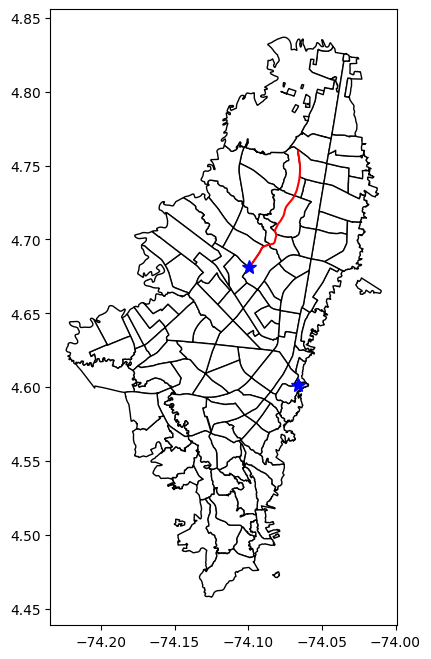

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 100)
filtro = ~upla["UPlNombre"].str.contains("RIO")
upla.loc[filtro,:].plot(ax = ax, color = 'white', edgecolor = 'black');
ciclovias.iloc[0:1,:].plot(ax = ax, color = "red"); 
plt.plot(*uniandes.coords[:][0], "*", color = "b", markersize = 10);
plt.plot(*punto_cercano.coords[:][0], "*", color = "b", markersize = 10);

Y calculemos la distancia:

In [ ]:
coords_1 = [[punto_cercano.coords[:][0][1], punto_cercano.coords[:][0][0]]]
coords_2 = [[uniandes.coords[:][0][1], uniandes.coords[:][0][0]]]

geodesic(coords_1, coords_2).km

9.51461662718672

La distancia entre Uniandes y la ciclovía es de 4.4 kilometros.  Un punto importante a notar es que [geopandas](https://geopandas.org/) guarda las coordenadas como (lon, lat), pero  [geopy](https://geopy.readthedocs.io/en/stable/) las interpreta  al revés (lat, lon).

Calculemos ahora iterativamente  todas las distancias entre las ciclovías, Uniandes y el Banco de la República que vamos a almacenar en el `DataFrame: distancias`

In [ ]:
distancias = pd.DataFrame(columns = ["Lugar", "Lugar coordenadas", "Ciclovía", 
    "Punto cercano", "Distancia"])


for p in range(db.shape[0]):
    punto = db.geometry[p]
    lugar = db.lugar[p]
    for c in range(ciclovias.shape[0]):
        ciclovia = ciclovias.geometry[c]
        punto_cercano = nearest_points(ciclovia, punto)[0]
        distancia = geodesic(
            (punto_cercano.coords[:][0][1], punto_cercano.coords[:][0][0]),
            (punto.coords[:][0][1], punto.coords[:][0][0])).km
        distancias = distancias.append({
            "Lugar": lugar, 
            "Lugar coordenadas": punto.coords[:][0],
            "Ciclovía": ciclovias.geometry[0].coords[:],
            "Punto cercano": punto_cercano.coords[:][0],
            "Distancia": distancia}, ignore_index=True)

<ipython-input-20-d076b16d8be9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distancias = distancias.append({
<ipython-input-20-d076b16d8be9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distancias = distancias.append({
<ipython-input-20-d076b16d8be9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distancias = distancias.append({
<ipython-input-20-d076b16d8be9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distancias = distancias.append({
<ipython-input-20-d076b16d8be9>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distancias = 

In [ ]:
distancias

,Lugar,Lugar coordenadas,Ciclovía,Punto cercano,Distancia
0,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.09933499981858, 4.681028500156323)",9.514617
1,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.07534630043656, 4.698749500142881)",10.789900
2,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.05537869921812, 4.655037399830839)",6.035283
3,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.03274159962268, 4.712836499631161)",12.855895
4,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.0553975000587, 4.654946500099967)",6.025017
5,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.13897589979534, 4.620164300432467)",8.311916
6,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.10024160026457, 4.6252806005495115)",4.579450
7,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.07244938458894, 4.604421479308411)",0.741596
8,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.06887450026153, 4.610310000048883)",1.002875
9,Uniandes,"(-74.066391, 4.60159)","[(-74.06572639926411, 4.760347099936292), (-74...","(-74.09931490001411, 4.647512300501227)",6.255692


Tenemos entonces todas las distancias entre Uniandes y el BanRep, y los puntos más cercanos de las ciclovías.

## Uniones espaciales

Otra operación que usamos a menudo, es  la unión espacial. Siguiendo el ejemplo anterior, supongamos que queremos agregar una columna a nuestra `db` que indique la UPL a la cual pertencen. Para esto podemos usar una unión espacial que va a unir la información entre dos bases espaciales.

Para esta operación utilizaremos la funcion `sjoin()`:

In [ ]:
upla.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
db.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
union = gpd.sjoin(db, upla)

union

,lugar,lat,long,geometry,coordenadas,index_right,UPlCodigo,UPlTipo,UPlNombre,UPlAAdmini,UPlArea,SHAPE_Leng,SHAPE_Area
0,Uniandes,4.601590,-74.066391,POINT (-74.06639 4.60159),"(-74.066391, 4.60159)",86,UPZ94,1,LA CANDELARIA,"Dec 492 de 2007 Mod.=Dec 172 de 2010, 336 de 2...",2.060243e+06,0.067156,0.000168
1,Banco de la República,4.602151,-74.072210,POINT (-74.07221 4.60215),"(-74.07221, 4.602151)",29,UPZ93,1,LAS NIEVES,"Dec 492 de 2007 Mod.=Dec 486 de 2017, 791 de 2...",1.725739e+06,0.061851,0.000141


Podemos ver entonces que se crearon nuevas columnas con la información de las UPLs. Para Uniandes aparece que está en La Candelaria y para el BanRep en Las Nieves.

## Visualizaciones interactivas

`Python` ofrece además la capacidad de generar visualizaciones interactivas, en esta sección usaremos la librerías [folium](https://pypi.org/project/folium/) y [Bokeh](https://bokeh.org/) para generar estas visualizaciones. 

La forma más sencilla de visualizar nuestros datos sobre un mapa interactivo es haciendo uso de la librería [folium](https://pypi.org/project/folium/). 

Esta libreria requiere que primero especifiquemos la capa base del mapa y luego se le agregen las capas deseadas:

In [ ]:
#importamos la librería
import folium

#Mapa base
map = folium.Map(location = [4.65283,-74.054339], tiles = "OpenStreetMap", zoom_start = 10)
# Otras opciones de tiles
#Stamen Terrain, Toner, and Watercolor

#capa bares
for i in range(0,len(bares)):
   folium.Marker(
      location=[bares.iloc[i]['LATITUD'], bares.iloc[i]['LONGITUD']],
       popup=bares.iloc[i]['NOMBRE_EST'],
   ).add_to(map)


#Display el mapa
map


Podemos también agregar la capa de los polígonos de las UPL 

In [ ]:
#Primero removemos las UPL cuyo nombre contienen Rio
upla_filt=upla.loc[~upla["UPlNombre"].str.contains("RIO"),:]

#Agregamos la capa de polígonos con un popup con el nombre de la UPL
for _, r in upla_filt.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': '#FFFFFF'})
    folium.Popup(r['UPlNombre']).add_to(geo_j)
    geo_j.add_to(map)

map

Finalmente agregamos la ciclovias:

In [ ]:
#Agregamos la capa de lineas para las ciclovias
ciclo=ciclovias.to_crs(4686)

folium.Choropleth(
 ciclo,
    line_weight=2,
    line_color='red'
).add_to(map)

map

[Folium](https://pypi.org/project/folium/) entonces nos permite con facilidad ubicar nuestros datos en un mapa interactivo. 

Notemos que omití graficar los supermercados, esto se debe a que al ser más de 1000 datos le puede tomar a [folium](https://pypi.org/project/folium/) un tiempo considerable graficarlos. 


Para superar esto una excelente alternativa  es [bokeh](https://bokeh.org/), un submódulo de la librería [datashader](https://datashader.org/). (Te invito que explores este  [enlace](https://anaconda.org/jbednar/nyc_taxi/notebook) para ver más detalles sobre este submódulo).

Este paquete, sin embargo, es un poco más técnico que [folium](https://pypi.org/project/folium/)  por lo cual requiere que se transformen los datos antes de visualizarlos. Lo primero será quedarnos con los puntos y desechar los polígonos:

In [ ]:
from shapely.geometry import Point

#Removemos algunos supermercados sin latitudes y longitudes
super_points=super[super.geom_type=="Point"]
len(super_points)

1161

Luego convertimos los puntos en un objeto `GeoSeries`. Notemos que estamos definiendo explicitamente la proyección inicial de los puntos:

In [ ]:
# Convertimos los puntos en un objeto GeoSeries.
xys_wb = gpd.GeoSeries(super_points.geometry, crs = "epsg:4326")

Este paquete requiere además que los datos se encuentre en proyección Web Mercator, EPSG: 3857:

In [ ]:
# Vamos a reproyectar a Web Mercator
xys_wb = xys_wb.to_crs(epsg = 3857)

Require ademas que las coordenadas esten separadas:

In [ ]:
# Separamos las coordenadas en x e y
x_wb = xys_wb.apply(lambda i: i.x)
y_wb = xys_wb.apply(lambda i: i.y)

Ahora que tenemos nuestros objetos en el formato adecuado, vamos a crear una función para visualizar el mapa con [bokeh](https://bokeh.org/). 

In [ ]:
from bokeh.plotting import figure, output_notebook, show

Para graficar necesitamos una serie de pasos:

1) Indicar que se va a desplegar dentro de un Jupyter Notebook:

In [ ]:
output_notebook() 

2) Delimitamos los bordes del mapa, para ello podemos usar los valores máximos y mínimos de las coordenas a graficar:

In [ ]:
# Extraemos los puntos más extremos para definir los límites del mapa
minx, miny, maxx, maxy = xys_wb.total_bounds
y_range = miny, maxy 
x_range = minx, maxx 


3) Definimos el gráfico base, con estos valores mínimos, tamaño de la gráfica y otras opciones, como ser el color y el tamaño:

In [ ]:
def base_plot(tools = 'pan,wheel_zoom,reset', plot_width = 600, plot_height = 400, **plot_args):
    p = figure(tools = tools, plot_width = plot_width, plot_height = plot_height,
        x_range = x_range, y_range = y_range, outline_line_color = None,
        min_border = 0, min_border_left = 0, min_border_right = 0,
        min_border_top = 0, min_border_bottom = 0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

# Definimos que nuestros puntos tengan color morado (#800080) y sean de tamaño 4
options = dict(line_color = None, fill_color = '#800080', size = 4)

4) Definimos la capa base. Para ello necesitamos importar un proveedor de los servicios de cartografía. Este proveedor será el que visualizará las calles, ríos, parques, nombres de las ciudades, etc. Para ver los proveedores disponibles puede ingresar a https://docs.bokeh.org/en/latest/docs/reference/tile_providers.html#bokeh-tile-providers

In [ ]:
from bokeh.tile_providers import STAMEN_TERRAIN, get_provider

Estamos ahora en condiciones de llamar el mapa base, con la capa del proveedor que elegimos, añadimos la ubicaciones de los supermercados y visualizamos:

In [ ]:

# Creamos un mapa delimitado por las coordenadas más extremas 
p = base_plot()

cartografia = get_provider(STAMEN_TERRAIN)
p.add_tile(cartografia)

# Le añadimos las ubicaciones de los supermercados como puntos
p.circle(x = x_wb, y = y_wb, **options)

# Visualizamos nuestro mapa
show(p)

Note que [bokeh](https://bokeh.org/) es sustancialmente más veloz que [folium](https://pypi.org/project/folium/), pero también más intrincado.


# Estimación de Densidades para el Análisis de Puntos Calientes. 

# Estimacion de densidades

- Buscan estimar $f(x)$ sin asumir una forma funcional particular, sólo suponiendo ciertas condiciones de regularidad de la densidad (suavidad, diferenciabilidad) 


-  ¿Cómo se interpreta la información muestral?


-  Si observamos más datos “cerca” de $x$ que de $x'$ inferimos que $f(x )> f(x') $

##  KDE



$$\hat{f_h}(x)=\frac{1}{nh}\sum_{i=1}^nK\left(\frac{x-x_i}{h}\right)$$

Donde $K$ es una función no negativa llamada kernel y $h > 0$ es un parámetro de suavización llamado ancho de banda. 


- Generemos un ejemplo

In [ ]:
#Llamamos librerias
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
from sklearn.datasets import make_blobs

- Genero datos aleatorios con `make_blobs`

In [ ]:
X, y_true = make_blobs(n_samples=200, centers=[(-74.06383, 4.638495), (-74.03144, 4.693142), (-74.07207, 4.596605)],
                       cluster_std=0.01, random_state=123)

In [ ]:
df=pd.DataFrame(X)
df=df.rename(columns={0: "Longitud", 1: "Latitud"})

In [ ]:
df['cluster_true']=y_true
df.head()

,Longitud,Latitud,cluster_true
0,-74.042959,4.640139,0
1,-74.062020,4.650274,0
2,-74.062623,4.645977,0
3,-74.075827,4.582808,2
4,-74.075309,4.594722,2


In [ ]:
import folium

map = folium.Map(location = [df['Latitud'].mean(),df['Longitud'].mean()], tiles = "OpenStreetMap", zoom_start = 10)


colour = ['red',
    'orange',
    'green']

def colorCall(val):
  val = int(val)
  return colour[val]

#capa clusters de teatros
for lat, lon, c in zip(df['Latitud'], df['Longitud'], df['cluster_true']):
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        fill_color = colorCall(c),
        fill=True,
        color=colorCall(c),
        fill_opacity=0.7
        ).add_to(map)
        

#Display el mapa
#map 

- Generemos como centro la [Plaza de Bolívar](https://en.wikipedia.org/wiki/Plaza_de_Bol%C3%ADvar,_Bogot%C3%A1)

In [ ]:
PB = pd.DataFrame({
    "lugar": ["Plaza de Bolívar"],
    "Latitud": [4.598128],
    "Longitud": [-74.076044]
    })
PB

,lugar,Latitud,Longitud
0,Plaza de Bolívar,4.598128,-74.076044


In [ ]:
folium.Marker(
      location=[PB.iloc[0]['Latitud'], PB.iloc[0]['Longitud']]
).add_to(map)
map

- Calculo distancias

In [ ]:
import geopandas as gpd
df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitud, df.Latitud))
df.crs = "EPSG:4326"

df["coordenadas"] = df["geometry"].apply(lambda x: x.representative_point().coords[:][0])

In [ ]:

PB = gpd.GeoDataFrame(PB, geometry = gpd.points_from_xy(PB.Longitud, PB.Latitud))
PB.crs = "EPSG:4326"
PB["coordenadas"] = PB["geometry"].apply(lambda x: x.representative_point().coords[:][0])
PB



,lugar,Latitud,Longitud,geometry,coordenadas
0,Plaza de Bolívar,4.598128,-74.076044,POINT (-74.07604 4.59813),"(-74.076044, 4.598128)"


In [ ]:
from geopy.distance import geodesic

distances = []

for p in range(df.shape[0]):
    punto = df.coordenadas[p]
    distancia = geodesic(
            (PB.coordenadas[:][0][1], PB.coordenadas[:][0][0]),
            (punto[1], punto[0])).km
    distances.append(distancia)
    
df['distancias'] = distances

df.head()

,Longitud,Latitud,cluster_true,geometry,coordenadas,distancias
0,-74.042959,4.640139,0,POINT (-74.04296 4.64014),"(-74.04295886640412, 4.640139412302298)",5.921117
1,-74.062020,4.650274,0,POINT (-74.06202 4.65027),"(-74.06201964870402, 4.650273619388086)",5.972624
2,-74.062623,4.645977,0,POINT (-74.06262 4.64598),"(-74.06262252636903, 4.645977156171872)",5.496815
3,-74.075827,4.582808,2,POINT (-74.07583 4.58281),"(-74.07582749910982, 4.582807750213413)",1.694305
4,-74.075309,4.594722,2,POINT (-74.07531 4.59472),"(-74.07530859783785, 4.594722031415063)",0.385376


In [ ]:
df['distancias'].describe()

count    200.000000
mean       5.893941
std        4.397348
min        0.074107
25%        1.816320
50%        4.734447
75%       11.180087
max       14.651486
Name: distancias, dtype: float64

- Estimo densidades

<AxesSubplot:xlabel='distancias', ylabel='Density'>

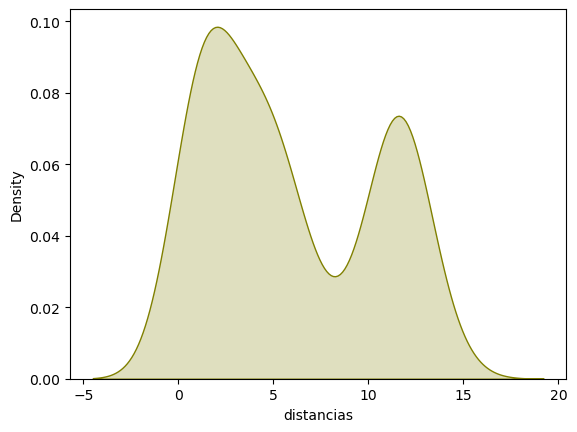

In [ ]:
import seaborn as sns

#sns.histplot(df['distancias'], multiple="layer", kde=True)
sns.kdeplot(df['distancias'], shade=True, bw='scott', color="olive")

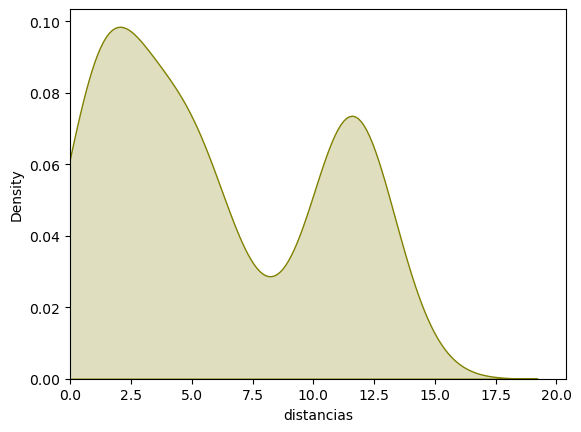

In [ ]:
import matplotlib.pyplot as plt

sns.kdeplot(df['distancias'], shade=True, bw='scott', color="olive")
plt.xlim(0, None)
plt.show()

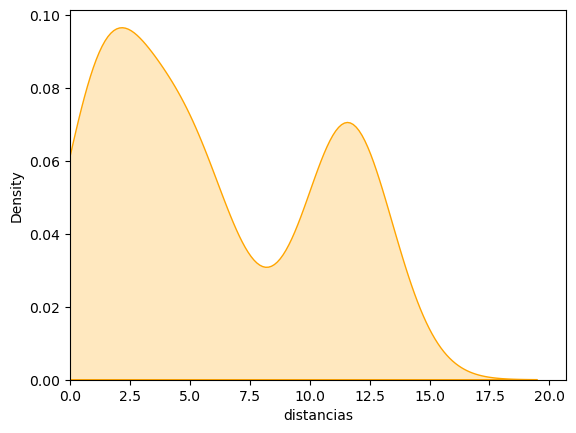

In [ ]:
sns.kdeplot(df['distancias'], shade=True, bw='silverman', color="orange")
plt.xlim(0, None)
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

bandwidths = 10 ** np.linspace(-2, .001, 20)
bandwidths[0:20]


array([0.01      , 0.01274429, 0.0162417 , 0.0206989 , 0.02637929,
       0.03361855, 0.04284447, 0.05460225, 0.06958671, 0.08868335,
       0.11302067, 0.14403687, 0.18356483, 0.23394042, 0.29814055,
       0.37995909, 0.48423105, 0.61711829, 0.78647371, 1.00230524])

In [ ]:
grid = { 
    'bandwidth': bandwidths,
    'kernel': ['gaussian','epanechnikov', 'tophat', 'linear']
}

gridCV = GridSearchCV(KernelDensity(),
                    param_grid=grid,
                    cv=5,verbose=0)
vals=df['distancias'].to_numpy().reshape(-1, 1)
gridCV.fit(vals)

GridSearchCV(cv=5, estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.01      , 0.01274429, 0.0162417 , 0.0206989 , 0.02637929,
       0.03361855, 0.04284447, 0.05460225, 0.06958671, 0.08868335,
       0.11302067, 0.14403687, 0.18356483, 0.23394042, 0.29814055,
       0.37995909, 0.48423105, 0.61711829, 0.78647371, 1.00230524]),
                         'kernel': ['gaussian', 'epanechnikov', 'tophat',
                                    'linear']})

In [ ]:
gridCV.best_params_

{'bandwidth': 0.48423104735421807, 'kernel': 'gaussian'}

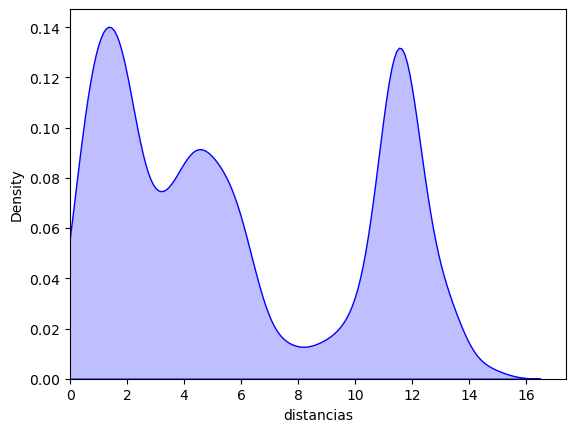

In [ ]:
sns.kdeplot(df['distancias'], shade=True, bw=0.14, color="blue")
plt.xlim(0, None)
plt.show()

In [ ]:
#Cargamos la librería 

import statsmodels.api as sm
db=df[['Latitud','Longitud']]
dens_u = sm.nonparametric.KDEMultivariate(data=db, var_type='cc', bw='cv_ml')


In [ ]:
dens_u.bw

array([0.00564645, 0.00579426])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

# Grilla de valores dentro del rango observado (2 dimensiones)
x = np.linspace(min(db.Longitud)-.01, max(db.Longitud)+.01, 200)
y = np.linspace(min(db.Latitud)-.01, max(db.Latitud)+.01, 200)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack(( yy.flatten(),xx.flatten()))

densidad_pred=dens_u.pdf(data_predict=grid)
densidad_pred

array([8.12772229e-02, 1.00832418e-01, 1.24288778e-01, ...,
       5.31363070e-06, 3.48522717e-06, 2.30624200e-06])

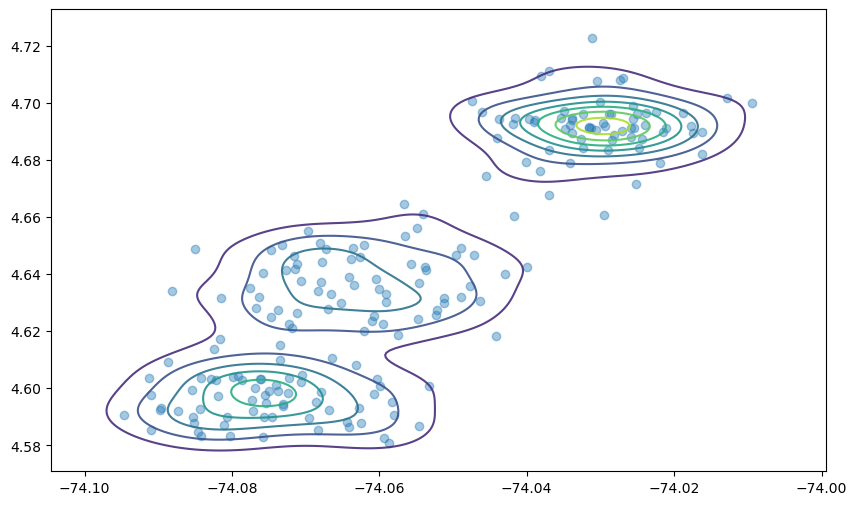

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))


ax.scatter(db.Longitud, db.Latitud, alpha=0.4)
ax.contour(
    xx, yy, densidad_pred.reshape(xx.shape),
    alpha =0.9
)


- Ejemplo Taller

In [ ]:
import pandas as pd
dta = pd.read_csv('data/Chicago_delitos_verano_2019.csv')
dta.head()

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728
3,2019-06-01T11:35:00Z,homicidio,16,41.960145,-87.699654
4,2019-06-02T09:39:00Z,homicidio,37,41.804773,-87.633256


In [ ]:
barrios = gpd.read_file('data/Areas_comunitarias_Chicago.zip')
barrios=barrios.rename(columns={'area_numbe': "nro_area_comunitaria"})
barrios["nro_area_comunitaria"]=barrios["nro_area_comunitaria"].astype(int)
barrios.head()


,area,area_num_1,nro_area_comunitaria,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry
0,0.0,35,35,0.0,0.0,DOUGLAS,0.0,4.600462e+07,31027.054510,"POLYGON ((-87.60914 41.84469, -87.60915 41.844..."
1,0.0,36,36,0.0,0.0,OAKLAND,0.0,1.691396e+07,19565.506153,"POLYGON ((-87.59215 41.81693, -87.59231 41.816..."
2,0.0,37,37,0.0,0.0,FULLER PARK,0.0,1.991670e+07,25339.089750,"POLYGON ((-87.62880 41.80189, -87.62879 41.801..."
3,0.0,38,38,0.0,0.0,GRAND BOULEVARD,0.0,4.849250e+07,28196.837157,"POLYGON ((-87.60671 41.81681, -87.60670 41.816..."
4,0.0,39,39,0.0,0.0,KENWOOD,0.0,2.907174e+07,23325.167906,"POLYGON ((-87.59215 41.81693, -87.59215 41.816..."


In [ ]:
# Table of tipo de crimen por barrio
crimen_barrio = pd.crosstab(index=dta["nro_area_comunitaria"], 
                           columns=dta["tipo_crimen"],
                           margins=True)



perc_crimen=crimen_barrio/crimen_barrio.iloc[77,:]
perc_crimen=perc_crimen.rename(columns={'homicidio': "homicidio_perc",'robo': "robo_perc",'All': "All_perc"})
pd.set_option('display.max_rows', perc_crimen.shape[0]+1)
perc_crimen

tipo_crimen,homicidio_perc,robo_perc,All_perc
nro_area_comunitaria,,,
1,0.013889,0.021303,0.021243
2,0.000000,0.015906,0.015777
3,0.000000,0.015111,0.014988
4,0.000000,0.009601,0.009523
5,0.000000,0.005624,0.005578
6,0.006944,0.043288,0.042993
7,0.020833,0.029654,0.029582
8,0.000000,0.088564,0.087846
9,0.000000,0.001079,0.001071


In [ ]:
db=barrios[['nro_area_comunitaria','community']]
db=db.merge(perc_crimen, on='nro_area_comunitaria', how='left')
db=db.merge(crimen_barrio, on='nro_area_comunitaria', how='left')
db

,nro_area_comunitaria,community,homicidio_perc,robo_perc,All_perc,homicidio,robo,All
0,35,DOUGLAS,0.000000,0.010566,0.010481,0,186,186
1,36,OAKLAND,0.006944,0.002670,0.002705,1,47,48
2,37,FULLER PARK,0.013889,0.002727,0.002817,2,48,50
3,38,GRAND BOULEVARD,0.013889,0.012668,0.012678,2,223,225
4,39,KENWOOD,0.000000,0.006590,0.006536,0,116,116
5,4,LINCOLN SQUARE,0.000000,0.009601,0.009523,0,169,169
6,40,WASHINGTON PARK,0.034722,0.004942,0.005184,5,87,92
7,41,HYDE PARK,0.000000,0.011021,0.010931,0,194,194
8,42,WOODLAWN,0.013889,0.009373,0.009410,2,165,167
9,1,ROGERS PARK,0.013889,0.021303,0.021243,2,375,377


<AxesSubplot:xlabel='community'>

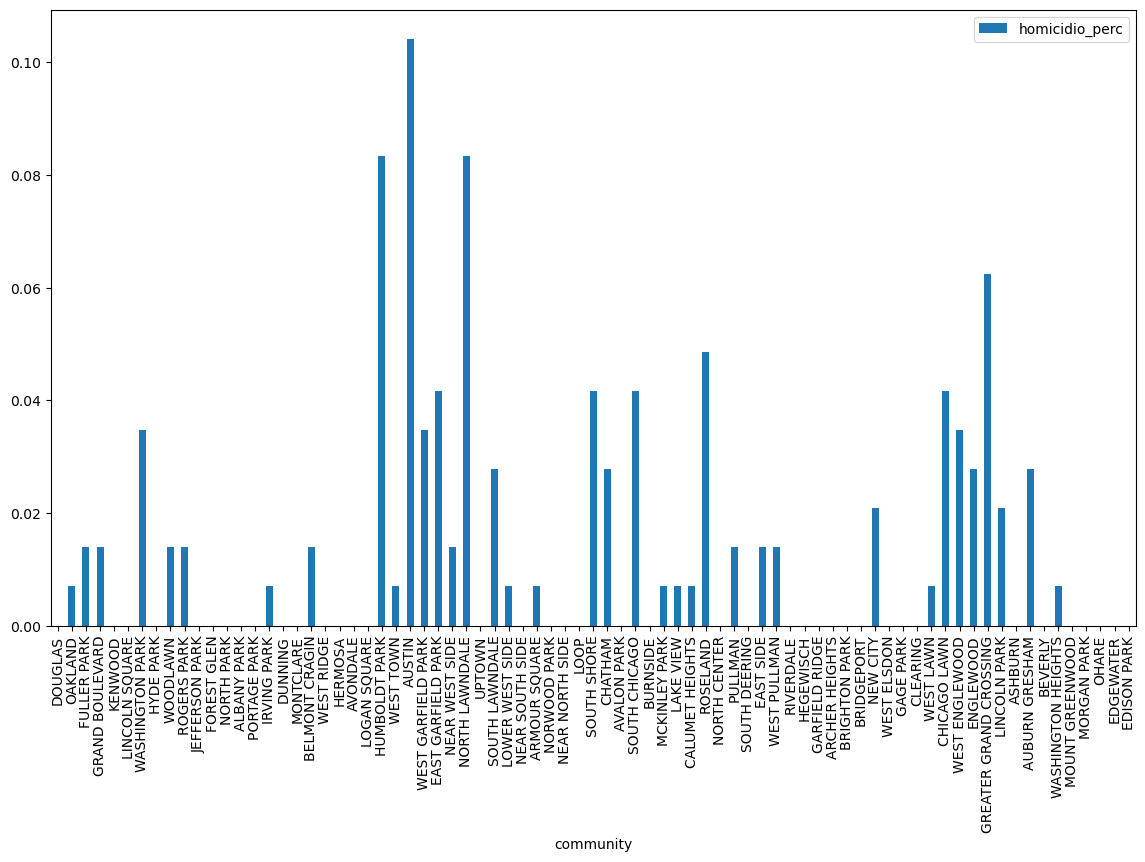

In [ ]:
fig, ax = plt.subplots(figsize = (14, 8), dpi = 100)
db.plot.bar(ax=ax,x='community', y='homicidio_perc', rot=90)

In [ ]:
df  = barrios.merge(db, on='nro_area_comunitaria', how='left')

gdf = gpd.GeoDataFrame(df)
#gdf

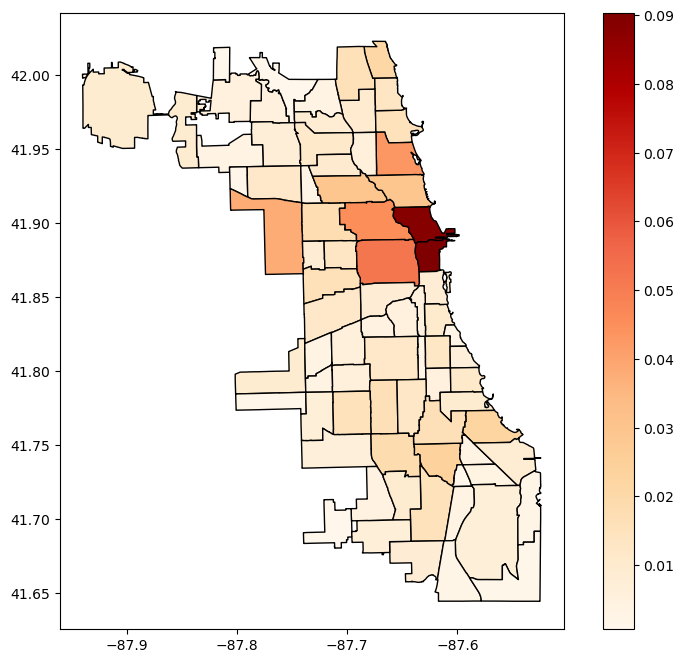

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8), dpi = 100)
gdf.plot(ax = ax, column='robo_perc' ,edgecolor = 'black', legend = True, cmap='OrRd');

- Bajando datos de a poco

<div style="max-width:500px">
<img src = "figs/elephant.webp" />
</div>

<AxesSubplot:>

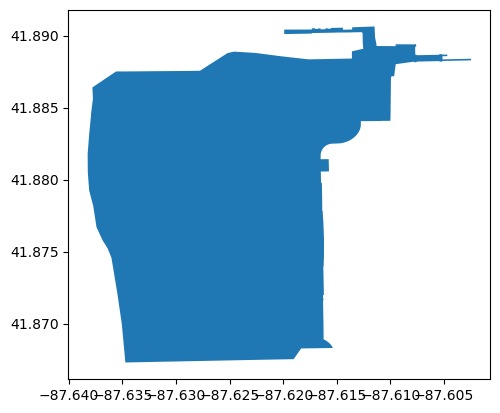

In [ ]:
from pyrosm import OSM, get_data

# Bajamos los datos para  Chicago
fp_chi = get_data("Chicago")

# Inicializamos el lector para Chicago
osm = OSM(fp_chi)

bb_loop = osm.get_boundaries(name="Loop")
bb_loop.plot()

In [ ]:
from pyrosm import OSM, get_data

# Bajamos los datos para  Chicago
fp_chi = get_data("Colombia")

Downloaded Protobuf data 'colombia-latest.osm.pbf' (238.34 MB) to:
'/var/folders/lp/bhbhb__n1_z91_rjfqljxcdc0000gn/T/pyrosm/colombia-latest.osm.pbf'


In [ ]:
# Obtener bounding box
bbox_geom = bb_loop['geometry'].values[0]

# Bajar los datos
osm_loop = OSM(fp_chi, bounding_box=bbox_geom)

In [ ]:
landuse_loop = osm_loop.get_landuse(custom_filter={'landuse': ['retail',"commercial"]})

In [ ]:
landuse_loop.size

1280

<AxesSubplot:>

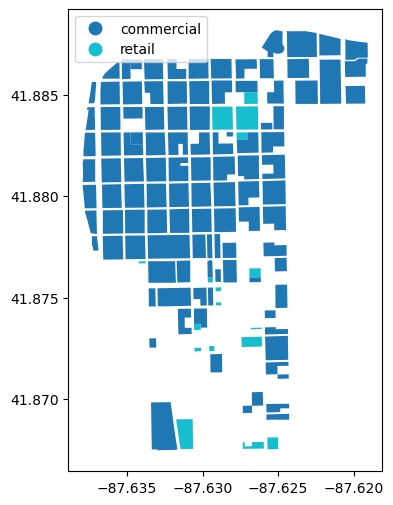

In [ ]:
landuse_loop.plot(column='landuse', legend=True, figsize=(10,6))

In [ ]:
bb_fg = osm.get_boundaries(name="Forest Glen")
# Obtener bounding box
bbox_geom_fg = bb_fg['geometry'].values[0]

# Bajar los datos
osm_fg = OSM(fp_chi, bounding_box=bbox_geom_fg)
landuse_fg = osm_fg.get_landuse(custom_filter={'landuse': ['retail',"commercial"]})
landuse_fg.size

112

<AxesSubplot:>

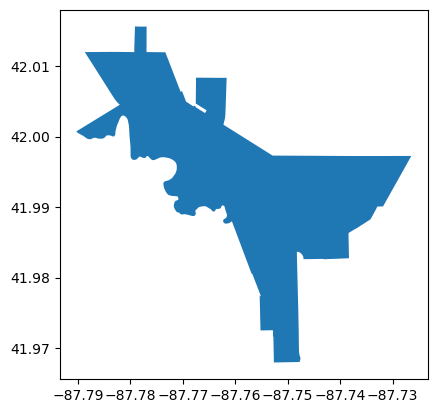

In [ ]:
bb_fg.plot()

<AxesSubplot:>

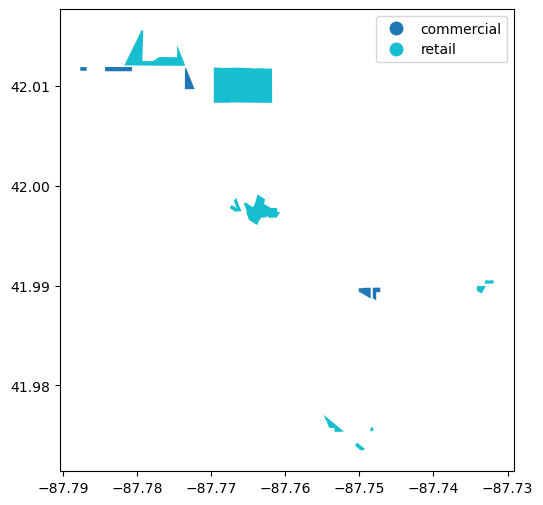

In [ ]:
landuse_fg.plot(column='landuse', legend=True, figsize=(10,6))

# Referencias

- Bivand, R. S., Pebesma, E. J., Gómez-Rubio, V., & Pebesma, E. J. (2008). Applied spatial data analysis with R (Vol. 747248717, pp. 237-268). New York: Springer.
- Dougherty, J., & Ilyankou, I. (2021). "Hands-On Data Visualization".  O'Reilly Media, Inc.
- ESRI, Environmental Systems Research Institute. (1998). “ESRI Shapefile Technical Description.” Disponible en: https://www.esri.com/library/whitepapers/pdfs/shapefile.pdf. Accedido el 04/02/2022
- MacWright, T. "lon lat lon lat". Disponible en https://macwright.com/lonlat/. Accedido el 04/02/2022
- Tenkanen, H. "Spatial data science for sustainable development". Disponible en https://sustainability-gis.readthedocs.io/en/latest/index.html. Accedido el 04/02/2022